## 🔧 1. Setup & System Info

In [14]:
# Install packages jika belum ada
# !pip install torch transformers scikit-learn pandas numpy matplotlib seaborn tqdm psutil

import torch
import sys
import platform
import psutil

print('=' * 60)
print('🖥️  SYSTEM INFO - CPU MODE')
print('=' * 60)
print(f'Python: {sys.version}')
print(f'PyTorch: {torch.__version__}')
print(f'Platform: {platform.system()} {platform.release()}')
print()

# CPU Info
print('💻 CPU INFO:')
print(f'   CPU Cores (Physical): {psutil.cpu_count(logical=False)}')
print(f'   CPU Cores (Logical): {psutil.cpu_count(logical=True)}')
print(f'   CPU Freq: {psutil.cpu_freq().current:.0f} MHz' if psutil.cpu_freq() else '   CPU Freq: N/A')
print()

# Memory Info
memory = psutil.virtual_memory()
print('💾 MEMORY INFO:')
print(f'   Total RAM: {memory.total / 1024**3:.1f} GB')
print(f'   Available: {memory.available / 1024**3:.1f} GB')
print(f'   Used: {memory.percent}%')
print()

# Force CPU device
device = torch.device('cpu')
print(f'🎮 Using device: {device}')
print('⚠️  Training on CPU - This will be slower than GPU')

# Set number of threads for PyTorch
num_threads = psutil.cpu_count(logical=True)
torch.set_num_threads(num_threads)
print(f'🔧 PyTorch threads: {num_threads}')

🖥️  SYSTEM INFO - CPU MODE
Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
PyTorch: 2.1.2+cu118
Platform: Windows 10

💻 CPU INFO:
   CPU Cores (Physical): 16
   CPU Cores (Logical): 24
   CPU Freq: 3200 MHz

💾 MEMORY INFO:
   Total RAM: 31.7 GB
   Available: 16.4 GB
   Used: 48.4%

🎮 Using device: cpu
⚠️  Training on CPU - This will be slower than GPU
🔧 PyTorch threads: 24


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    classification_report, confusion_matrix, f1_score
)
from sklearn.utils import resample
import random
import os
import copy
import json
from datetime import datetime
import time
import subprocess

warnings.filterwarnings('ignore')

# =====================================================
# CPU INFO & TDP ESTIMATION
# =====================================================
def get_cpu_info():
    """Get CPU name and estimate TDP"""
    cpu_name = platform.processor()
    
    # Try to get more detailed CPU info on Windows
    try:
        result = subprocess.run(
            ['wmic', 'cpu', 'get', 'name'],
            capture_output=True, text=True, shell=True
        )
        if result.returncode == 0:
            lines = result.stdout.strip().split('\n')
            if len(lines) > 1:
                cpu_name = lines[1].strip()
    except:
        pass
    
    return cpu_name

def estimate_cpu_tdp(cpu_name):
    """
    Estimate CPU TDP based on CPU name.
    This is an approximation based on common CPU models.
    """
    cpu_name_lower = cpu_name.lower()
    
    # Intel Desktop CPUs
    if 'i9' in cpu_name_lower and 'k' in cpu_name_lower:
        return 125  # Intel Core i9 K-series
    elif 'i9' in cpu_name_lower:
        return 95   # Intel Core i9
    elif 'i7' in cpu_name_lower and 'k' in cpu_name_lower:
        return 95   # Intel Core i7 K-series
    elif 'i7' in cpu_name_lower and ('h' in cpu_name_lower or 'hq' in cpu_name_lower):
        return 45   # Intel Core i7 H-series (Laptop)
    elif 'i7' in cpu_name_lower and 'u' in cpu_name_lower:
        return 15   # Intel Core i7 U-series (Ultrabook)
    elif 'i7' in cpu_name_lower:
        return 65   # Intel Core i7
    elif 'i5' in cpu_name_lower and ('h' in cpu_name_lower or 'hq' in cpu_name_lower):
        return 45   # Intel Core i5 H-series (Laptop)
    elif 'i5' in cpu_name_lower and 'u' in cpu_name_lower:
        return 15   # Intel Core i5 U-series (Ultrabook)
    elif 'i5' in cpu_name_lower:
        return 65   # Intel Core i5
    elif 'i3' in cpu_name_lower:
        return 35   # Intel Core i3
    
    # AMD Desktop CPUs
    elif 'ryzen 9' in cpu_name_lower:
        return 105  # AMD Ryzen 9
    elif 'ryzen 7' in cpu_name_lower and ('h' in cpu_name_lower or 'hs' in cpu_name_lower):
        return 45   # AMD Ryzen 7 H-series (Laptop)
    elif 'ryzen 7' in cpu_name_lower and 'u' in cpu_name_lower:
        return 15   # AMD Ryzen 7 U-series (Ultrabook)
    elif 'ryzen 7' in cpu_name_lower:
        return 65   # AMD Ryzen 7
    elif 'ryzen 5' in cpu_name_lower and ('h' in cpu_name_lower or 'hs' in cpu_name_lower):
        return 45   # AMD Ryzen 5 H-series (Laptop)
    elif 'ryzen 5' in cpu_name_lower and 'u' in cpu_name_lower:
        return 15   # AMD Ryzen 5 U-series (Ultrabook)
    elif 'ryzen 5' in cpu_name_lower:
        return 65   # AMD Ryzen 5
    elif 'ryzen 3' in cpu_name_lower:
        return 35   # AMD Ryzen 3
    
    # Default for unknown CPUs
    else:
        return 45   # Default assumption (laptop-like)

# Get CPU info
CPU_NAME = get_cpu_info()
CPU_TDP_WATTS = estimate_cpu_tdp(CPU_NAME)

print(f'💻 CPU Detected: {CPU_NAME}')
print(f'⚡ Estimated TDP: {CPU_TDP_WATTS}W')

# =====================================================
# CPU MONITORING FUNCTIONS
# =====================================================
def get_cpu_memory_usage():
    """Get current CPU/RAM memory usage"""
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024**2
    return memory_mb

def get_system_stats():
    """Get comprehensive system stats"""
    process = psutil.Process(os.getpid())
    return {
        'cpu_percent': psutil.cpu_percent(interval=0.1),
        'memory_used_mb': process.memory_info().rss / 1024**2,
        'memory_percent': process.memory_percent(),
        'system_memory_percent': psutil.virtual_memory().percent
    }

def estimate_power_usage(cpu_percent, tdp_watts):
    """
    Estimate power usage based on CPU utilization and TDP.
    Formula: Power = TDP * (CPU% / 100) * efficiency_factor
    The efficiency_factor accounts for the fact that CPUs rarely use full TDP.
    """
    efficiency_factor = 0.8  # CPUs typically use 60-80% of TDP at full load
    return tdp_watts * (cpu_percent / 100) * efficiency_factor

class CPUMonitor:
    """Monitor CPU/RAM usage and estimate power during training"""
    def __init__(self, cpu_tdp=45):
        self.cpu_tdp = cpu_tdp
        self.reset()
    
    def reset(self):
        self.memory_samples = []
        self.cpu_samples = []
        self.power_samples = []
        self.start_time = None
        self.end_time = None
        self.total_energy_wh = 0
    
    def start(self):
        self.reset()
        self.start_time = time.time()
    
    def sample(self):
        """Take a sample of current system stats"""
        stats = get_system_stats()
        self.memory_samples.append(stats['memory_used_mb'])
        self.cpu_samples.append(stats['cpu_percent'])
        
        # Estimate power usage
        power = estimate_power_usage(stats['cpu_percent'], self.cpu_tdp)
        self.power_samples.append(power)
    
    def stop(self):
        self.end_time = time.time()
        
        # Calculate total energy consumption
        if self.power_samples and self.start_time:
            duration_hours = (self.end_time - self.start_time) / 3600
            avg_power = np.mean(self.power_samples)
            self.total_energy_wh = avg_power * duration_hours
    
    def get_summary(self):
        """Get summary of resource usage"""
        summary = {
            'duration_seconds': 0,
            'duration_formatted': '0:00:00',
            'peak_memory_mb': 0,
            'avg_memory_mb': 0,
            'avg_cpu_percent': 0,
            'max_cpu_percent': 0,
            'avg_power_w': 0,
            'max_power_w': 0,
            'total_energy_wh': 0,
            'total_energy_kwh': 0
        }
        
        if self.start_time and self.end_time:
            duration = self.end_time - self.start_time
            summary['duration_seconds'] = duration
            hours, remainder = divmod(int(duration), 3600)
            minutes, seconds = divmod(remainder, 60)
            summary['duration_formatted'] = f'{hours}:{minutes:02d}:{seconds:02d}'
        
        if self.memory_samples:
            summary['peak_memory_mb'] = max(self.memory_samples)
            summary['avg_memory_mb'] = np.mean(self.memory_samples)
        
        if self.cpu_samples:
            summary['avg_cpu_percent'] = np.mean(self.cpu_samples)
            summary['max_cpu_percent'] = max(self.cpu_samples)
        
        if self.power_samples:
            summary['avg_power_w'] = np.mean(self.power_samples)
            summary['max_power_w'] = max(self.power_samples)
            summary['total_energy_wh'] = self.total_energy_wh
            summary['total_energy_kwh'] = self.total_energy_wh / 1000
        
        return summary

# Initialize CPU monitor with detected TDP
cpu_monitor = CPUMonitor(cpu_tdp=CPU_TDP_WATTS)

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print('\n✓ Libraries imported')
print('✓ CPU monitoring functions defined (with power estimation)')
print(f'✓ Device: {device}')

✓ Libraries imported
✓ CPU monitoring functions defined
✓ Device: cpu


## 📊 2. Load Data

📊 DATA OVERVIEW
Total samples: 15,000
Columns: ['userName', 'content', 'content_clean', 'score', 'at', 'sentiment']

📈 Sentiment Distribution:
sentiment
positive    5000
neutral     5000
negative    5000
Name: count, dtype: int64


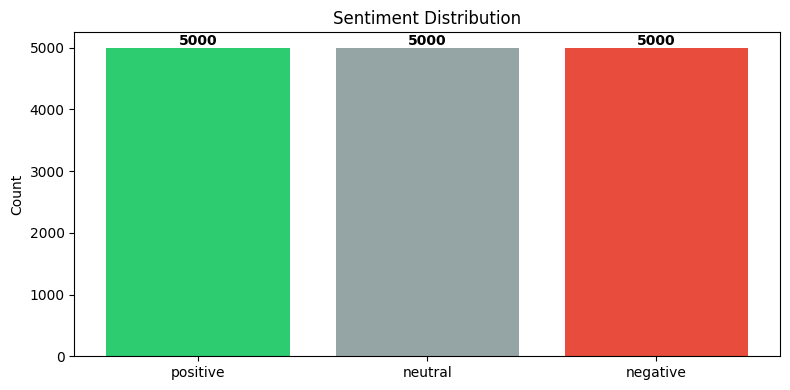

In [16]:
# Load data dari folder data/
DATA_PATH = 'data/gojek_reviews_final_augmented.csv'

if not os.path.exists(DATA_PATH):
    print(f'❌ File tidak ditemukan: {DATA_PATH}')
    print('\n📁 Files yang ada:')
    if os.path.exists('data'):
        for f in os.listdir('data'):
            print(f'   - data/{f}')
else:
    df = pd.read_csv(DATA_PATH)
    
    print('=' * 60)
    print('📊 DATA OVERVIEW')
    print('=' * 60)
    print(f'Total samples: {len(df):,}')
    print(f'Columns: {df.columns.tolist()}')
    print(f'\n📈 Sentiment Distribution:')
    print(df['sentiment'].value_counts())
    
    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    colors = {'negative': '#e74c3c', 'neutral': '#95a5a6', 'positive': '#2ecc71'}
    counts = df['sentiment'].value_counts()
    bars = ax.bar(counts.index, counts.values, color=[colors[s] for s in counts.index])
    ax.set_title('Sentiment Distribution')
    ax.set_ylabel('Count')
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                str(count), ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

## ⚖️ 3. Prepare Data

In [17]:
# Check if data is already balanced
counts = df['sentiment'].value_counts()
min_count = counts.min()
max_count = counts.max()

if (max_count - min_count) / max_count < 0.1:
    print('✓ Data sudah balanced!')
    df_balanced = df.copy()
else:
    print('⚠️ Melakukan undersampling...')
    df_balanced = pd.DataFrame()
    for sentiment in ['negative', 'neutral', 'positive']:
        df_class = df[df['sentiment'] == sentiment]
        df_sampled = resample(df_class, replace=False, n_samples=min_count, random_state=42)
        df_balanced = pd.concat([df_balanced, df_sampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f'\n📊 Data untuk training: {len(df_balanced):,} samples')
print(df_balanced['sentiment'].value_counts())

✓ Data sudah balanced!

📊 Data untuk training: 15,000 samples
sentiment
positive    5000
neutral     5000
negative    5000
Name: count, dtype: int64


In [18]:
# Label mapping
LABEL_MAP = {'negative': 0, 'neutral': 1, 'positive': 2}
LABEL_NAMES = ['negative', 'neutral', 'positive']
NUM_CLASSES = 3

df_balanced['label'] = df_balanced['sentiment'].map(LABEL_MAP)

# Split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    df_balanced, test_size=0.3, random_state=42, stratify=df_balanced['label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
)

print('=' * 60)
print('📂 DATA SPLITS')
print('=' * 60)
print(f'Train: {len(train_df):,} samples ({len(train_df)/len(df_balanced)*100:.1f}%)')
print(f'Val:   {len(val_df):,} samples ({len(val_df)/len(df_balanced)*100:.1f}%)')
print(f'Test:  {len(test_df):,} samples ({len(test_df)/len(df_balanced)*100:.1f}%)')

📂 DATA SPLITS
Train: 10,500 samples (70.0%)
Val:   2,250 samples (15.0%)
Test:  2,250 samples (15.0%)


## ⚙️ 4. Configuration (CPU Optimized)

In [19]:
# === HYPERPARAMETERS ===
# Optimized untuk CPU Training - 5 Epochs

CONFIG = {
    # Model
    'model_name': 'indobenchmark/indobert-base-p1',
    'max_length': 128,
    'num_classes': NUM_CLASSES,
    
    # Training - CPU Optimized
    'batch_size': 16,  # Smaller batch for CPU
    'epochs': 5,       # 5 epochs only
    'learning_rate': 2e-5,
    
    # Anti-Overfitting
    'dropout_rate': 0.5,
    'attention_dropout': 0.2,
    'weight_decay': 0.01,
    'label_smoothing': 0.1,
    'warmup_ratio': 0.1,
    'max_grad_norm': 1.0,
    'early_stopping_patience': 5,
    
    # Data Augmentation
    'word_dropout_prob': 0.15,
    
    # Layer Freezing - More aggressive for CPU
    'freeze_layers': 10,  # Freeze 10 dari 12 layer untuk speed
    
    # R-Drop
    'rdrop_alpha': 0.3,
}

print('=' * 60)
print('⚙️  CONFIGURATION - CPU MODE')
print('=' * 60)
for key, value in CONFIG.items():
    print(f'{key}: {value}')

# Estimate training time
print('\n⏱️  ESTIMATED TRAINING TIME:')
print('   With CPU, expect ~5-15 minutes per epoch')
print(f'   Total estimated: ~{CONFIG["epochs"] * 5} - {CONFIG["epochs"] * 15} minutes')

⚙️  CONFIGURATION - CPU MODE
model_name: indobenchmark/indobert-base-p1
max_length: 128
num_classes: 3
batch_size: 16
epochs: 5
learning_rate: 2e-05
dropout_rate: 0.5
attention_dropout: 0.2
weight_decay: 0.01
label_smoothing: 0.1
warmup_ratio: 0.1
max_grad_norm: 1.0
early_stopping_patience: 5
word_dropout_prob: 0.15
freeze_layers: 10
rdrop_alpha: 0.3

⏱️  ESTIMATED TRAINING TIME:
   With CPU, expect ~5-15 minutes per epoch
   Total estimated: ~25 - 75 minutes


## 📦 5. Dataset & DataLoader

In [20]:
# Load tokenizer
print('Loading tokenizer...')
tokenizer = BertTokenizer.from_pretrained(CONFIG['model_name'])
print(f'✓ Tokenizer loaded: {CONFIG["model_name"]}')

class SentimentDataset(Dataset):
    """Dataset dengan augmentation"""
    
    def __init__(self, texts, labels, tokenizer, max_length=128, 
                 augment=False, word_dropout_prob=0.15):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment
        self.word_dropout_prob = word_dropout_prob
    
    def __len__(self):
        return len(self.texts)
    
    def _augment_text(self, text):
        if not self.augment:
            return text
        
        text = str(text)
        words = text.split()
        
        if len(words) <= 3:
            return text
        
        aug_type = random.random()
        
        if aug_type < 0.3:
            # Word dropout
            words = [w for w in words if random.random() > self.word_dropout_prob]
        elif aug_type < 0.5:
            # Word swap
            if len(words) > 2:
                idx = random.randint(0, len(words) - 2)
                words[idx], words[idx + 1] = words[idx + 1], words[idx]
        
        return ' '.join(words) if words else text
    
    def __getitem__(self, idx):
        text = self._augment_text(self.texts[idx])
        
        encoding = self.tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

Loading tokenizer...
✓ Tokenizer loaded: indobenchmark/indobert-base-p1
✓ Tokenizer loaded: indobenchmark/indobert-base-p1


In [21]:
# Create datasets
train_dataset = SentimentDataset(
    train_df['content_clean'].values,
    train_df['label'].values,
    tokenizer,
    max_length=CONFIG['max_length'],
    augment=True,
    word_dropout_prob=CONFIG['word_dropout_prob']
)

val_dataset = SentimentDataset(
    val_df['content_clean'].values,
    val_df['label'].values,
    tokenizer,
    max_length=CONFIG['max_length'],
    augment=False
)

test_dataset = SentimentDataset(
    test_df['content_clean'].values,
    test_df['label'].values,
    tokenizer,
    max_length=CONFIG['max_length'],
    augment=False
)

# Create dataloaders - num_workers=0 for CPU
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, 
                          drop_last=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f'\n✓ Datasets created:')
print(f'  Train: {len(train_dataset)} samples, {len(train_loader)} batches')
print(f'  Val:   {len(val_dataset)} samples, {len(val_loader)} batches')
print(f'  Test:  {len(test_dataset)} samples, {len(test_loader)} batches')


✓ Datasets created:
  Train: 10500 samples, 656 batches
  Val:   2250 samples, 141 batches
  Test:  2250 samples, 141 batches


## 🧠 6. Model (CPU Optimized)

In [22]:
class IndoBERTSentimentClassifier(nn.Module):
    """
    IndoBERT dengan optimisasi untuk CPU:
    - Freeze lebih banyak layer (10/12)
    - Simple classifier
    """
    
    def __init__(self, model_name, num_classes, dropout_rate=0.5, 
                 attention_dropout=0.2, freeze_layers=10):
        super(IndoBERTSentimentClassifier, self).__init__()
        
        # Load pretrained BERT
        self.bert = BertModel.from_pretrained(model_name)
        self.hidden_size = self.bert.config.hidden_size
        
        # Freeze embeddings
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        
        # Freeze first N encoder layers (more for CPU)
        for i in range(freeze_layers):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = False
        
        print(f'✓ Froze embeddings and first {freeze_layers} encoder layers')
        print(f'  Only layers {freeze_layers}-11 are trainable ({12-freeze_layers} layers)')
        
        # Regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(self.hidden_size)
        
        # Simple classifier
        self.fc = nn.Linear(self.hidden_size, num_classes)
        
        # Initialize
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.pooler_output
        x = self.layer_norm(pooled_output)
        x = self.dropout(x)
        logits = self.fc(x)
        
        return logits

In [23]:
# Initialize model
print('Loading IndoBERT model (this may take a moment on CPU)...')
model = IndoBERTSentimentClassifier(
    model_name=CONFIG['model_name'],
    num_classes=CONFIG['num_classes'],
    dropout_rate=CONFIG['dropout_rate'],
    attention_dropout=CONFIG['attention_dropout'],
    freeze_layers=CONFIG['freeze_layers']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f'\n✓ Model loaded to {device}')
print(f'  Total parameters: {total_params:,}')
print(f'  Trainable: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)')
print(f'  Frozen: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)')
print(f'\n💡 Fewer trainable params = Faster CPU training')

Loading IndoBERT model (this may take a moment on CPU)...
✓ Froze embeddings and first 10 encoder layers
  Only layers 10-11 are trainable (2 layers)

✓ Model loaded to cpu
  Total parameters: 124,445,187
  Trainable: 14,770,179 (11.9%)
  Frozen: 109,675,008 (88.1%)

💡 Fewer trainable params = Faster CPU training
✓ Froze embeddings and first 10 encoder layers
  Only layers 10-11 are trainable (2 layers)

✓ Model loaded to cpu
  Total parameters: 124,445,187
  Trainable: 14,770,179 (11.9%)
  Frozen: 109,675,008 (88.1%)

💡 Fewer trainable params = Faster CPU training


## 📉 7. Loss, Optimizer & Scheduler

In [24]:
# Loss function dengan label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

# Optimizer - hanya untuk trainable parameters
no_decay = ['bias', 'LayerNorm.weight', 'layer_norm.weight']
trainable_params_list = [(n, p) for n, p in model.named_parameters() if p.requires_grad]

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in trainable_params_list if not any(nd in n for nd in no_decay)],
        'weight_decay': CONFIG['weight_decay']
    },
    {
        'params': [p for n, p in trainable_params_list if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

optimizer = AdamW(optimizer_grouped_parameters, lr=CONFIG['learning_rate'])

# Scheduler
total_steps = len(train_loader) * CONFIG['epochs']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f'✓ Optimizer: AdamW (lr={CONFIG["learning_rate"]}, wd={CONFIG["weight_decay"]})')
print(f'✓ Scheduler: Linear warmup ({warmup_steps} warmup, {total_steps} total)')
print(f'✓ Loss: CrossEntropy with label_smoothing={CONFIG["label_smoothing"]}')

✓ Optimizer: AdamW (lr=2e-05, wd=0.01)
✓ Scheduler: Linear warmup (328 warmup, 3280 total)
✓ Loss: CrossEntropy with label_smoothing=0.1


## 🏋️ 8. Training Functions

In [25]:
def compute_kl_loss(p, q):
    """KL divergence for R-Drop"""
    p_loss = F.kl_div(F.log_softmax(p, dim=-1), F.softmax(q, dim=-1), reduction='batchmean')
    q_loss = F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='batchmean')
    return (p_loss + q_loss) / 2

def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, 
                max_grad_norm, rdrop_alpha=0.3):
    """Train dengan R-Drop regularization"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # R-Drop: 2 forward passes
        logits1 = model(input_ids, attention_mask)
        logits2 = model(input_ids, attention_mask)
        
        # Cross entropy loss
        ce_loss = (criterion(logits1, labels) + criterion(logits2, labels)) / 2
        
        # KL divergence loss
        kl_loss = compute_kl_loss(logits1, logits2)
        
        # Total loss
        loss = ce_loss + rdrop_alpha * kl_loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        avg_logits = (logits1 + logits2) / 2
        preds = torch.argmax(avg_logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1

def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

class EarlyStopping:
    """Early stopping dengan gap monitoring"""
    
    def __init__(self, patience=5, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None
    
    def __call__(self, score, model):
        if self.mode == 'max':
            is_improvement = self.best_score is None or score > self.best_score + self.min_delta
        else:
            is_improvement = self.best_score is None or score < self.best_score - self.min_delta
        
        if is_improvement:
            self.best_score = score
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop

print('✓ Training functions defined')

✓ Training functions defined


## 🚀 9. Training Loop

In [ ]:
# Training history
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [],
    'gap': [],
    'epoch_time': [],
    'memory_used_mb': [],
    'cpu_percent': [],
    'power_draw_w': []  # Estimated power consumption
}

early_stopping = EarlyStopping(
    patience=CONFIG['early_stopping_patience'], 
    mode='max'
)

print('=' * 60)
print('🚀 TRAINING STARTED - CPU MODE')
print('=' * 60)
print(f'Device: {device}')
print(f'CPU: {CPU_NAME}')
print(f'Estimated TDP: {CPU_TDP_WATTS}W')
print(f'Epochs: {CONFIG["epochs"]} | Patience: {CONFIG["early_stopping_patience"]}')
print(f'LR: {CONFIG["learning_rate"]} | Batch: {CONFIG["batch_size"]}')
print(f'Frozen Layers: {CONFIG["freeze_layers"]}/12 | Dropout: {CONFIG["dropout_rate"]}')
print('-' * 60)

# Show initial system stats
stats = get_system_stats()
print(f'💻 CPU Usage: {stats["cpu_percent"]:.1f}%')
print(f'💾 Memory: {stats["memory_used_mb"]:.0f} MB ({stats["memory_percent"]:.1f}%)')
print('-' * 60)

best_val_f1 = 0
best_epoch = 0
best_gap = float('inf')

# Start CPU monitoring
cpu_monitor.start()
training_start_time = datetime.now()

for epoch in range(CONFIG['epochs']):
    epoch_start = time.time()
    print(f'\n📍 Epoch {epoch + 1}/{CONFIG["epochs"]}')
    
    # Train
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, 
        device, CONFIG['max_grad_norm'], CONFIG['rdrop_alpha']
    )
    
    # Sample CPU stats after training
    cpu_monitor.sample()
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device
    )
    
    gap = train_acc - val_acc
    epoch_time = time.time() - epoch_start
    
    # Get current system stats and power estimate
    current_stats = get_system_stats()
    current_memory = current_stats['memory_used_mb']
    current_cpu = current_stats['cpu_percent']
    current_power = estimate_power_usage(current_cpu, CPU_TDP_WATTS)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['gap'].append(gap)
    history['epoch_time'].append(epoch_time)
    history['memory_used_mb'].append(current_memory)
    history['cpu_percent'].append(current_cpu)
    history['power_draw_w'].append(current_power)
    
    # Print metrics
    print(f'  Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}')
    print(f'  Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}')
    
    # Track best
    if val_f1 > best_val_f1 and gap < 0.10:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        best_gap = gap
        print(f'  ⭐ New best! F1: {val_f1:.4f}, Gap: {gap*100:.2f}%')
    
    # Gap status
    gap_status = '✅ Good' if gap < 0.05 else '⚡ OK' if gap < 0.10 else '⚠️ High'
    print(f'  📊 Gap: {gap*100:.2f}% {gap_status}')
    print(f'  ⏱️  Time: {epoch_time:.1f}s | 💾 RAM: {current_memory:.0f}MB | 💻 CPU: {current_cpu:.1f}% | ⚡ Power: ~{current_power:.1f}W')
    
    # Early stopping
    if early_stopping(val_f1, model):
        print(f'\n🛑 Early stopping at epoch {epoch + 1}')
        break

# Stop CPU monitoring
cpu_monitor.stop()
training_end_time = datetime.now()
total_time = training_end_time - training_start_time

# Load best model
if early_stopping.best_model is not None:
    model.load_state_dict(early_stopping.best_model)

# Get CPU summary
cpu_summary = cpu_monitor.get_summary()

# Electricity cost estimation (Indonesia average: Rp 1.444,70/kWh for 900VA)
ELECTRICITY_RATE_IDR = 1444.70
electricity_cost_idr = cpu_summary['total_energy_kwh'] * ELECTRICITY_RATE_IDR

print('\n' + '=' * 60)
print('✅ TRAINING COMPLETED')
print('=' * 60)
print(f'  Best epoch: {best_epoch}')
print(f'  Best Val F1: {best_val_f1:.4f}')
print(f'  Best Gap: {best_gap*100:.2f}%')
print()
print('⏱️  TIME STATISTICS:')
print(f'  Total Duration: {cpu_summary["duration_formatted"]}')
print(f'  Avg Time/Epoch: {np.mean(history["epoch_time"]):.1f}s')
print()
print('💾 MEMORY STATISTICS:')
print(f'  Peak RAM: {cpu_summary["peak_memory_mb"]:.0f} MB')
print(f'  Avg RAM: {cpu_summary["avg_memory_mb"]:.0f} MB')
print()
print('💻 CPU STATISTICS:')
print(f'  Avg CPU Usage: {cpu_summary["avg_cpu_percent"]:.1f}%')
print(f'  Max CPU Usage: {cpu_summary["max_cpu_percent"]:.1f}%')
print()
print('⚡ POWER & ELECTRICITY (Estimated):')
print(f'  CPU TDP: {CPU_TDP_WATTS}W')
print(f'  Avg Power: ~{cpu_summary["avg_power_w"]:.1f} W')
print(f'  Max Power: ~{cpu_summary["max_power_w"]:.1f} W')
print(f'  Total Energy: ~{cpu_summary["total_energy_wh"]:.2f} Wh ({cpu_summary["total_energy_kwh"]:.4f} kWh)')
print(f'  Electricity Cost: ~Rp {electricity_cost_idr:,.2f}')
print('=' * 60)

🚀 TRAINING STARTED - CPU MODE
Device: cpu
Epochs: 5 | Patience: 5
LR: 2e-05 | Batch: 16
Frozen Layers: 10/12 | Dropout: 0.5
------------------------------------------------------------
💻 CPU Usage: 16.8%
💾 Memory: 2637 MB (8.1%)
------------------------------------------------------------

📍 Epoch 1/5


Training:   0%|          | 0/656 [00:00<?, ?it/s]

  Train - Loss: 1.4249 | Acc: 0.5796 | F1: 0.5832
  Val   - Loss: 0.8669 | Acc: 0.6942 | F1: 0.6994
  ⭐ New best! F1: 0.6994, Gap: -11.47%
  📊 Gap: -11.47% ✅ Good
  ⏱️  Time: 1067.6s | 💾 RAM: 2765MB | 💻 CPU: 6.6%

📍 Epoch 2/5


Training:   0%|          | 0/656 [00:00<?, ?it/s]

  Train - Loss: 1.1299 | Acc: 0.6536 | F1: 0.6561
  Val   - Loss: 0.8001 | Acc: 0.7111 | F1: 0.7148
  ⭐ New best! F1: 0.7148, Gap: -5.75%
  📊 Gap: -5.75% ✅ Good
  ⏱️  Time: 1099.6s | 💾 RAM: 3641MB | 💻 CPU: 3.3%

📍 Epoch 3/5


Training:   0%|          | 0/656 [00:00<?, ?it/s]

  Train - Loss: 1.0237 | Acc: 0.6742 | F1: 0.6771
  Val   - Loss: 0.7928 | Acc: 0.7169 | F1: 0.7207
  ⭐ New best! F1: 0.7207, Gap: -4.27%
  📊 Gap: -4.27% ✅ Good
  ⏱️  Time: 1105.1s | 💾 RAM: 3603MB | 💻 CPU: 10.3%

📍 Epoch 4/5


Training:   0%|          | 0/656 [00:00<?, ?it/s]

  Train - Loss: 0.9636 | Acc: 0.6936 | F1: 0.6963
  Val   - Loss: 0.7780 | Acc: 0.7182 | F1: 0.7225
  ⭐ New best! F1: 0.7225, Gap: -2.46%
  📊 Gap: -2.46% ✅ Good
  ⏱️  Time: 1078.3s | 💾 RAM: 3494MB | 💻 CPU: 5.3%

📍 Epoch 5/5


Training:   0%|          | 0/656 [00:00<?, ?it/s]

  Train - Loss: 0.9225 | Acc: 0.7069 | F1: 0.7096
  Val   - Loss: 0.7796 | Acc: 0.7244 | F1: 0.7285
  ⭐ New best! F1: 0.7285, Gap: -1.75%
  📊 Gap: -1.75% ✅ Good
  ⏱️  Time: 1086.7s | 💾 RAM: 3550MB | 💻 CPU: 2.4%

✅ TRAINING COMPLETED
  Best epoch: 5
  Best Val F1: 0.7285
  Best Gap: -1.75%

⏱️  TIME STATISTICS:
  Total Duration: 1:30:38
  Avg Time/Epoch: 1087.5s

💾 MEMORY STATISTICS:
  Peak RAM: 3637 MB
  Avg RAM: 3475 MB

💻 CPU STATISTICS:
  Avg CPU Usage: 7.7%
  Max CPU Usage: 17.2%


## 📈 10. Training Visualization & Resource Usage

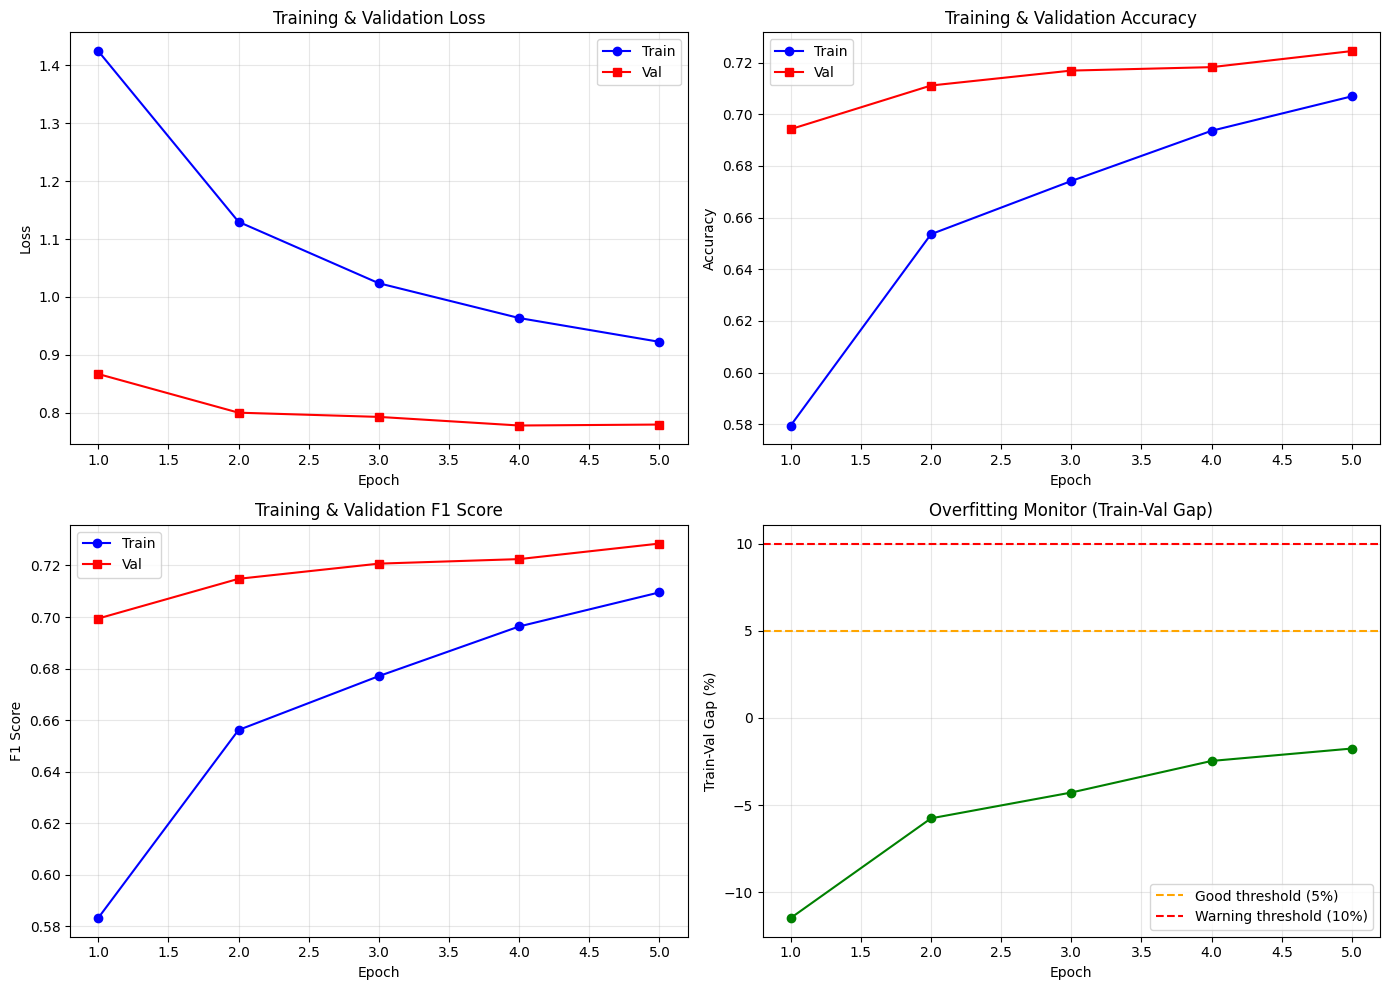

✓ Saved: training_history_cpu.png


In [27]:
# =====================================================
# FIGURE 1: Training Metrics
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-o', label='Train', markersize=6)
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-s', label='Val', markersize=6)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, history['train_acc'], 'b-o', label='Train', markersize=6)
axes[0, 1].plot(epochs_range, history['val_acc'], 'r-s', label='Val', markersize=6)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(epochs_range, history['train_f1'], 'b-o', label='Train', markersize=6)
axes[1, 0].plot(epochs_range, history['val_f1'], 'r-s', label='Val', markersize=6)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Training & Validation F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gap
axes[1, 1].plot(epochs_range, [g*100 for g in history['gap']], 'g-o', markersize=6)
axes[1, 1].axhline(y=5, color='orange', linestyle='--', label='Good threshold (5%)')
axes[1, 1].axhline(y=10, color='red', linestyle='--', label='Warning threshold (10%)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Train-Val Gap (%)')
axes[1, 1].set_title('Overfitting Monitor (Train-Val Gap)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_cpu.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: training_history_cpu.png')

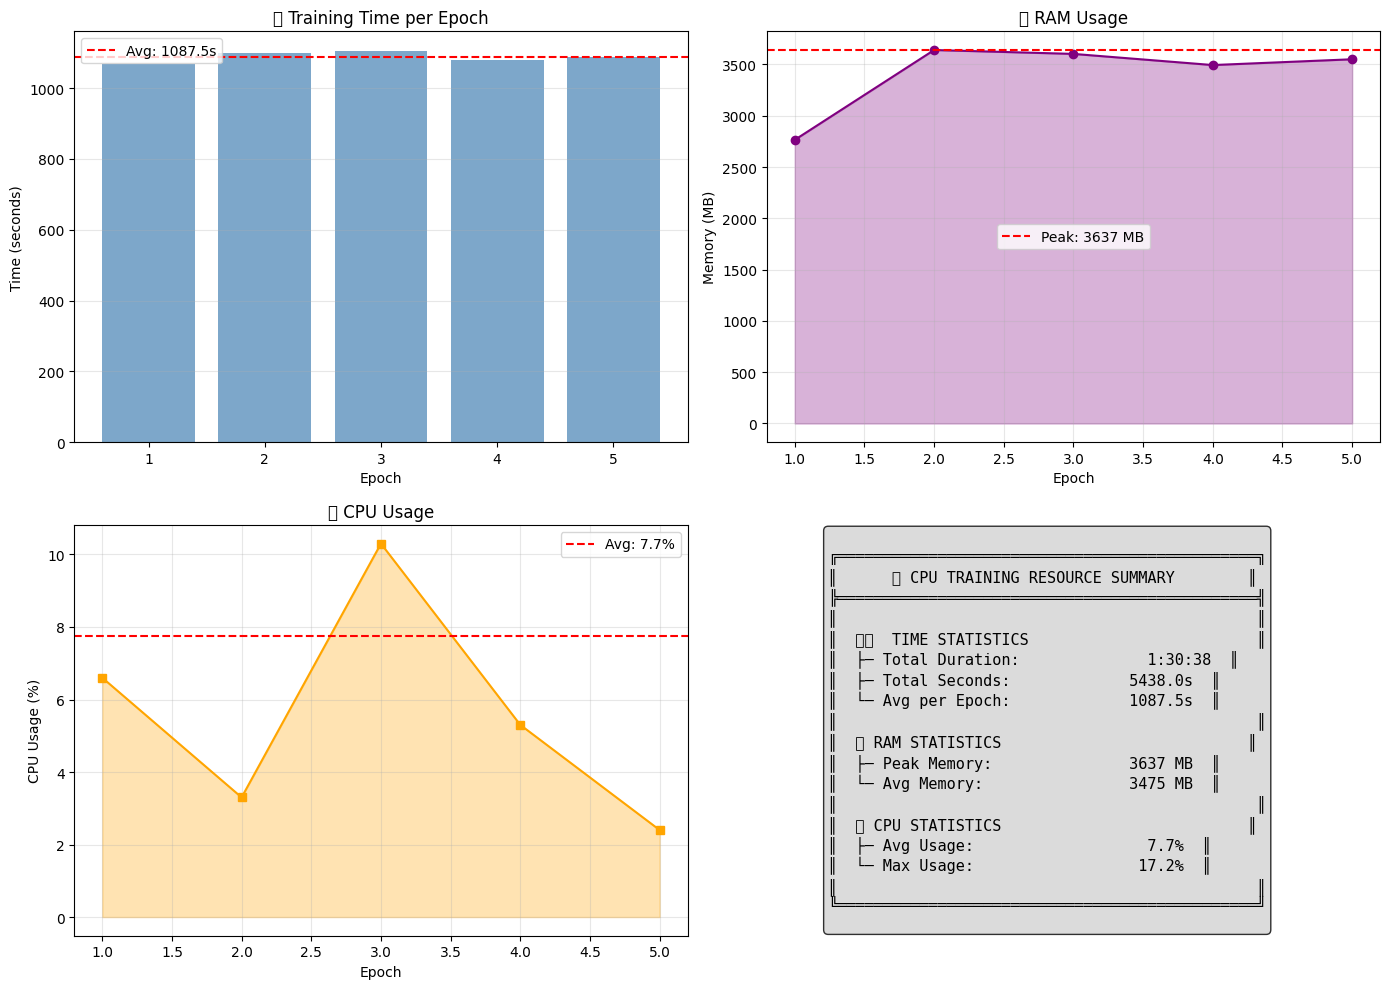

✓ Saved: resource_usage_cpu.png


In [ ]:
# =====================================================
# FIGURE 2: Resource Usage (Time, Memory, CPU, Power)
# =====================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
epochs_range = range(1, len(history['epoch_time']) + 1)

# Time per epoch
axes[0, 0].bar(epochs_range, history['epoch_time'], color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=np.mean(history['epoch_time']), color='red', linestyle='--', 
                   label=f'Avg: {np.mean(history["epoch_time"]):.1f}s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Time (seconds)')
axes[0, 0].set_title('⏱️ Training Time per Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Memory usage (RAM)
axes[0, 1].plot(epochs_range, history['memory_used_mb'], 'purple', marker='o', markersize=6)
axes[0, 1].axhline(y=cpu_summary['peak_memory_mb'], color='red', linestyle='--', 
                   label=f'Peak: {cpu_summary["peak_memory_mb"]:.0f} MB')
axes[0, 1].fill_between(epochs_range, 0, history['memory_used_mb'], alpha=0.3, color='purple')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Memory (MB)')
axes[0, 1].set_title('💾 RAM Usage')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CPU usage
axes[0, 2].plot(epochs_range, history['cpu_percent'], 'orange', marker='s', markersize=6)
axes[0, 2].axhline(y=cpu_summary['avg_cpu_percent'], color='red', linestyle='--', 
                   label=f'Avg: {cpu_summary["avg_cpu_percent"]:.1f}%')
axes[0, 2].fill_between(epochs_range, 0, history['cpu_percent'], alpha=0.3, color='orange')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('CPU Usage (%)')
axes[0, 2].set_title('💻 CPU Usage')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Power consumption (estimated)
axes[1, 0].plot(epochs_range, history['power_draw_w'], 'green', marker='d', markersize=6)
axes[1, 0].axhline(y=cpu_summary['avg_power_w'], color='red', linestyle='--', 
                   label=f'Avg: {cpu_summary["avg_power_w"]:.1f} W')
axes[1, 0].fill_between(epochs_range, 0, history['power_draw_w'], alpha=0.3, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Power (Watts)')
axes[1, 0].set_title(f'⚡ Estimated Power Consumption (TDP: {CPU_TDP_WATTS}W)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative energy (estimated)
cumulative_energy = []
energy_so_far = 0
for i, (t, p) in enumerate(zip(history['epoch_time'], history['power_draw_w'])):
    energy_so_far += (p * t / 3600)  # Convert to Wh
    cumulative_energy.append(energy_so_far)

axes[1, 1].plot(epochs_range, cumulative_energy, 'red', marker='^', markersize=6)
axes[1, 1].fill_between(epochs_range, 0, cumulative_energy, alpha=0.3, color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Energy (Wh)')
axes[1, 1].set_title('🔋 Cumulative Energy Consumption')
axes[1, 1].grid(True, alpha=0.3)

# Summary statistics as text
axes[1, 2].axis('off')
summary_text = f"""
╔══════════════════════════════════════════════════╗
║       📊 CPU TRAINING RESOURCE SUMMARY           ║
╠══════════════════════════════════════════════════╣
║                                                  ║
║  ⏱️  TIME STATISTICS                             ║
║  ├─ Total Duration: {cpu_summary['duration_formatted']:>24}  ║
║  ├─ Total Seconds:  {cpu_summary['duration_seconds']:>21.1f}s  ║
║  └─ Avg per Epoch:  {np.mean(history['epoch_time']):>21.1f}s  ║
║                                                  ║
║  💾 RAM STATISTICS                               ║
║  ├─ Peak Memory:    {cpu_summary['peak_memory_mb']:>19.0f} MB  ║
║  └─ Avg Memory:     {cpu_summary['avg_memory_mb']:>19.0f} MB  ║
║                                                  ║
║  💻 CPU STATISTICS                               ║
║  ├─ Avg Usage:      {cpu_summary['avg_cpu_percent']:>20.1f}%  ║
║  └─ Max Usage:      {cpu_summary['max_cpu_percent']:>20.1f}%  ║
║                                                  ║
║  ⚡ POWER & ELECTRICITY (Estimated)              ║
║  ├─ CPU TDP:        {CPU_TDP_WATTS:>20}W  ║
║  ├─ Avg Power:      {cpu_summary['avg_power_w']:>19.1f} W  ║
║  ├─ Max Power:      {cpu_summary['max_power_w']:>19.1f} W  ║
║  ├─ Total Energy:   {cpu_summary['total_energy_wh']:>17.2f} Wh  ║
║  └─ Elec. Cost:     Rp {electricity_cost_idr:>15,.2f}  ║
║                                                  ║
╚══════════════════════════════════════════════════╝
"""
axes[1, 2].text(0.05, 0.5, summary_text, fontsize=10, fontfamily='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('resource_usage_cpu.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: resource_usage_cpu.png')

## 🧪 11. Evaluation on Test Set

In [29]:
# Evaluate on test set
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print('=' * 60)
print('🧪 TEST SET EVALUATION')
print('=' * 60)
print(f'Test Accuracy: {test_acc*100:.2f}%')
print(f'Test F1 Score: {test_f1*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Classification report
print('\n📊 Classification Report:')
print(classification_report(test_labels, test_preds, target_names=LABEL_NAMES))

🧪 TEST SET EVALUATION
Test Accuracy: 72.84%
Test F1 Score: 73.19%
Test Loss: 0.7655

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.72      0.70       750
     neutral       0.63      0.67      0.65       750
    positive       0.90      0.79      0.85       750

    accuracy                           0.73      2250
   macro avg       0.74      0.73      0.73      2250
weighted avg       0.74      0.73      0.73      2250



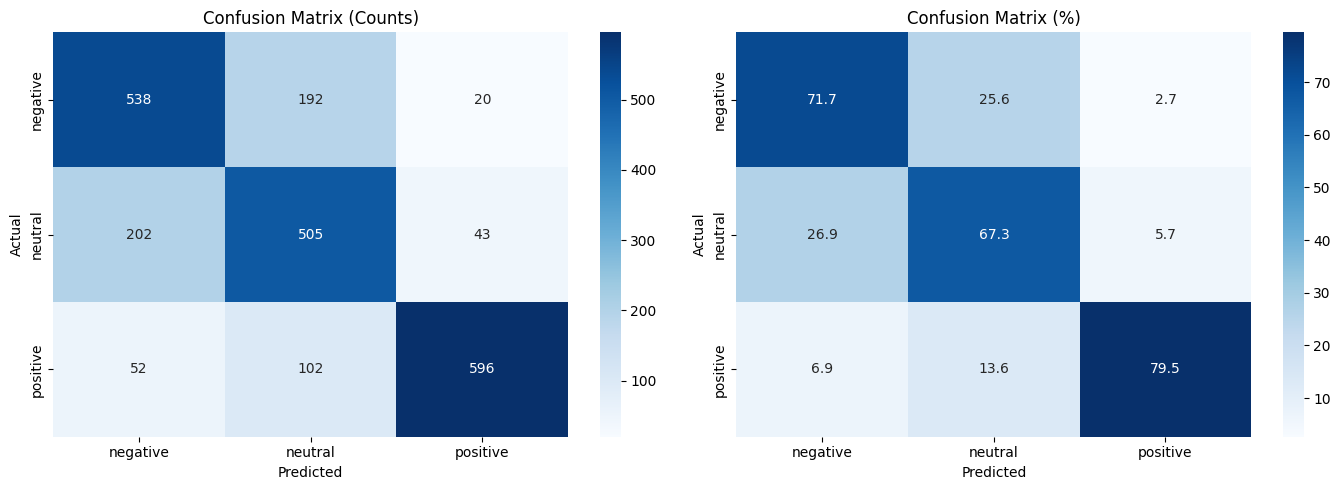

✓ Saved: confusion_matrix_cpu.png


In [30]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')

# Percentages
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (%)')

plt.tight_layout()
plt.savefig('confusion_matrix_cpu.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: confusion_matrix_cpu.png')

## 💾 12. Save Model

In [31]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Save model
model_path = 'models/indobert_sentiment_3class_cpu.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'label_map': LABEL_MAP,
    'label_names': LABEL_NAMES,
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'best_val_f1': best_val_f1,
    'best_gap': best_gap,
    'history': history,
    'training_device': 'cpu'
}, model_path)
print(f'✓ Model saved: {model_path}')

# Save tokenizer
tokenizer.save_pretrained('models/tokenizer')
print(f'✓ Tokenizer saved: models/tokenizer/')

# Save history
with open('models/training_history_cpu.json', 'w') as f:
    json.dump(history, f, indent=2)
print(f'✓ History saved: models/training_history_cpu.json')

# List saved files
print('\n📁 Saved files:')
for root, dirs, files in os.walk('models'):
    for file in files:
        filepath = os.path.join(root, file)
        size = os.path.getsize(filepath) / (1024*1024)
        print(f'   {filepath} ({size:.2f} MB)')

✓ Model saved: models/indobert_sentiment_3class_cpu.pt
✓ Tokenizer saved: models/tokenizer/
✓ History saved: models/training_history_cpu.json

📁 Saved files:
   models\indobert_sentiment_3class.pt (474.81 MB)
   models\indobert_sentiment_3class_cpu.pt (474.81 MB)
   models\training_history.json (0.01 MB)
   models\training_history_cpu.json (0.00 MB)
   models\training_report.json (0.01 MB)
   models\tokenizer\special_tokens_map.json (0.00 MB)
   models\tokenizer\tokenizer_config.json (0.00 MB)
   models\tokenizer\vocab.txt (0.25 MB)


## 🔮 13. Inference Demo

In [32]:
def predict_sentiment(text, model, tokenizer, device, label_names):
    """Predict sentiment untuk satu teks"""
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    
    return {
        'sentiment': label_names[pred],
        'confidence': probs[0][pred].item(),
        'probabilities': {
            label_names[i]: probs[0][i].item() 
            for i in range(len(label_names))
        }
    }

# Test
test_reviews = [
    "Aplikasi gojek sangat membantu, driver ramah dan cepat",
    "Driver nya lama banget, udah nunggu 1 jam gak datang",
    "Biasa aja sih aplikasinya",
    "Pelayanan buruk, tidak akan pakai lagi",
    "Mantap, makanan sampai dengan selamat dan masih hangat",
]

print('=' * 60)
print('🔮 INFERENCE DEMO')
print('=' * 60)

for review in test_reviews:
    result = predict_sentiment(review, model, tokenizer, device, LABEL_NAMES)
    emoji = {'negative': '😠', 'neutral': '😐', 'positive': '😊'}[result['sentiment']]
    print(f'\n📝 "{review[:50]}..."' if len(review) > 50 else f'\n📝 "{review}"')
    print(f'   {emoji} {result["sentiment"].upper()} ({result["confidence"]*100:.1f}%)')

🔮 INFERENCE DEMO

📝 "Aplikasi gojek sangat membantu, driver ramah dan c..."
   😊 POSITIVE (97.2%)

📝 "Driver nya lama banget, udah nunggu 1 jam gak data..."
   😠 NEGATIVE (85.5%)

📝 "Biasa aja sih aplikasinya"
📝 "Biasa aja sih aplikasinya"
   😊 POSITIVE (64.3%)

📝 "Pelayanan buruk, tidak akan pakai lagi"
   😠 NEGATIVE (86.2%)

📝 "Mantap, makanan sampai dengan selamat dan masih ha..."
   😊 POSITIVE (97.6%)

   😊 POSITIVE (64.3%)

📝 "Pelayanan buruk, tidak akan pakai lagi"
   😠 NEGATIVE (86.2%)

📝 "Mantap, makanan sampai dengan selamat dan masih ha..."
   😊 POSITIVE (97.6%)


## 📊 14. Final Summary

In [ ]:
final_gap = history['train_acc'][-1] - history['val_acc'][-1]
min_gap = min(history['gap'])

print('=' * 70)
print('📊 FINAL TRAINING SUMMARY - CPU MODE (5 EPOCHS)')
print('=' * 70)

print(f'''
🎯 MODEL PERFORMANCE:
   • Test Accuracy: {test_acc*100:.2f}%
   • Test F1 Score: {test_f1*100:.2f}%
   • Best Val F1: {best_val_f1*100:.2f}%

📈 OVERFITTING CHECK:
   • Final Gap: {final_gap*100:.2f}%
   • Best Gap: {best_gap*100:.2f}%
   • Status: {"✅ Good" if final_gap < 0.05 else "⚠️ Check" if final_gap < 0.10 else "❌ Overfitting"}

⏱️  TIME STATISTICS:
   • Total Training Time: {cpu_summary['duration_formatted']}
   • Average Time per Epoch: {np.mean(history['epoch_time']):.1f} seconds

💾 RAM STATISTICS:
   • Peak RAM Usage: {cpu_summary['peak_memory_mb']:.0f} MB
   • Average RAM Usage: {cpu_summary['avg_memory_mb']:.0f} MB

💻 CPU STATISTICS:
   • Average CPU Usage: {cpu_summary['avg_cpu_percent']:.1f}%
   • Max CPU Usage: {cpu_summary['max_cpu_percent']:.1f}%

⚡ POWER & ELECTRICITY (Estimated):
   • CPU Model: {CPU_NAME}
   • CPU TDP: {CPU_TDP_WATTS}W
   • Average Power: ~{cpu_summary['avg_power_w']:.1f} W
   • Max Power: ~{cpu_summary['max_power_w']:.1f} W
   • Total Energy: ~{cpu_summary['total_energy_wh']:.2f} Wh ({cpu_summary['total_energy_kwh']:.4f} kWh)
   • Electricity Cost: ~Rp {electricity_cost_idr:,.2f}

⚙️ CONFIGURATION:
   • Device: CPU
   • Epochs: {CONFIG['epochs']}
   • Batch Size: {CONFIG['batch_size']}
   • Layer Freezing: {CONFIG['freeze_layers']}/12
   • Dropout: {CONFIG['dropout_rate']}
   • Learning Rate: {CONFIG['learning_rate']}

💾 SAVED FILES:
   • models/indobert_sentiment_3class_cpu.pt
   • models/tokenizer/
   • models/training_history_cpu.json
   • models/training_report_cpu.json
   • training_history_cpu.png
   • resource_usage_cpu.png
   • confusion_matrix_cpu.png
''')

if test_acc >= 0.70 and final_gap < 0.05:
    print('🎉 GOOD! Model has decent accuracy and generalization for CPU training!')
elif test_acc >= 0.70:
    print('⚠️ Decent accuracy but watch for overfitting.')
elif final_gap < 0.05:
    print('✅ Good generalization but accuracy could improve with more epochs.')
else:
    print('💡 Consider more epochs or adjusting hyperparameters.')

print('=' * 70)
print('✅ CPU Training completed!')
print('=' * 70)

# Save complete training report
training_report = {
    'training_mode': 'CPU',
    'cpu_info': {
        'cpu_name': CPU_NAME,
        'cpu_tdp_watts': CPU_TDP_WATTS
    },
    'model_performance': {
        'test_accuracy': float(test_acc),
        'test_f1_score': float(test_f1),
        'best_val_f1': float(best_val_f1),
        'best_epoch': best_epoch,
        'final_gap': float(final_gap),
        'best_gap': float(best_gap)
    },
    'resource_usage': {
        'total_duration_seconds': cpu_summary['duration_seconds'],
        'total_duration_formatted': cpu_summary['duration_formatted'],
        'avg_epoch_time_seconds': float(np.mean(history['epoch_time'])),
        'peak_ram_mb': cpu_summary['peak_memory_mb'],
        'avg_ram_mb': cpu_summary['avg_memory_mb'],
        'avg_cpu_percent': cpu_summary['avg_cpu_percent'],
        'max_cpu_percent': cpu_summary['max_cpu_percent'],
        'avg_power_watts': cpu_summary['avg_power_w'],
        'max_power_watts': cpu_summary['max_power_w'],
        'total_energy_wh': cpu_summary['total_energy_wh'],
        'total_energy_kwh': cpu_summary['total_energy_kwh'],
        'electricity_cost_idr': electricity_cost_idr
    },
    'config': CONFIG,
    'history': history
}

with open('models/training_report_cpu.json', 'w') as f:
    json.dump(training_report, f, indent=2)
print('\n✓ Complete training report saved: models/training_report_cpu.json')

📊 FINAL TRAINING SUMMARY - CPU MODE

🎯 MODEL PERFORMANCE:
   • Test Accuracy: 72.84%
   • Test F1 Score: 73.19%
   • Best Val F1: 72.85%

📈 OVERFITTING CHECK:
   • Final Gap: -1.75%
   • Best Gap: -1.75%
   • Status: ✅ Good

⏱️  TIME & RESOURCE USAGE:
   • Total Training Time: 1:30:38
   • Average Time per Epoch: 1087.5 seconds
   • Peak RAM Usage: 3637 MB
   • Average RAM Usage: 3475 MB
   • Average CPU Usage: 7.7%
   • Max CPU Usage: 17.2%

⚙️ CONFIGURATION:
   • Device: CPU
   • Epochs: 5
   • Batch Size: 16
   • Layer Freezing: 10/12
   • Dropout: 0.5
   • Learning Rate: 2e-05

💾 SAVED FILES:
   • models/indobert_sentiment_3class_cpu.pt
   • models/tokenizer/
   • models/training_history_cpu.json
   • training_history_cpu.png
   • resource_usage_cpu.png
   • confusion_matrix_cpu.png

🎉 GOOD! Model has decent accuracy and generalization for CPU training!
✅ CPU Training completed!

✓ Complete training report saved: models/training_report_cpu.json
